**Домашнее задание**

Ссылки
- http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
- https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

Библиотеки, которые нужно установить:
- gensim
- razdel
- pymorphy2
- nltk

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [1]:
import pandas as pd
import numpy as np
import re

#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

#предобработка текстов
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                                precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# новости
news = pd.read_csv("../../data/ml_in_business/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
# Загрузим пользователей и списки последних прочитанных новостей
users = pd.read_csv("../../data/ml_in_business/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
#import nltk
#nltk.download('stopwords')

In [5]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [6]:
with open('../../data/ml_in_business/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [8]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-7-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 21.5 s


In [9]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 2s


А теперь в 3 строчки обучим нашу модель

In [10]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [11]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [12]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 32.9 s


In [13]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [14]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.6063354),
 (3, 0.05313657),
 (8, 0.049765132),
 (10, 0.08099723),
 (14, 0.1470387),
 (22, 0.045701683)]

In [15]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: снижение планета земля мочь это год день
topic_1: военный год станция северный турция товар технология
topic_2: суд тело дело следствие египет иск полиция
topic_3: млн британский великобритания год рейтинг место озеро
topic_4: который год это также россия nn время
topic_5: ребёнок гражданин исследование женщина человек пациент продукция
topic_6: украина статья президент банк украинский рф год
topic_7: пенсия лодка армения горный сбить годовой удар
topic_8: компания рост рынок год цена доход повышение
topic_9: это год который свой мочь весь человек
topic_10: мозг рак обращение знаменитый вирус университет кожа
topic_11: миссия солнце свет девочка девушка топливо автор
topic_12: год млрд проект компания российский тыс это
topic_13: погибнуть министерство запуск остров космос год человек
topic_14: рубль активность доклад россиянин документ законопроект мужчина
topic_15: население операция обнаружить район пострадать авария машина
topic_16: год университет стать который исследован

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [16]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [17]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.019771,0.0,0.000000,0.000000,0.000000,0.0,0.869455,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,4896,0.385323,0.0,0.054551,0.000000,0.537895,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,4897,0.606323,0.0,0.000000,0.053058,0.000000,0.0,0.000000,0.0,0.049744,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.045682,0.0,0.0
3,4898,0.358675,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,4899,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.443984,0.0,0.000000,...,0.0,0.249433,0.152884,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [18]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [19]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [20]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.31683493,
       0.06504198, 0.        , 0.        , 0.        , 0.24208035,
       0.        , 0.        , 0.        , 0.        , 0.02787341,
       0.        , 0.22315872, 0.        , 0.        , 0.        ,
       0.        , 0.03291405, 0.08117123, 0.        , 0.        ])

In [21]:
user_articles_list = users['articles'].iloc[33]

In [22]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [23]:
get_user_embedding(user_articles_list)

array([0.        , 0.06796408, 0.04681905, 0.        , 0.2103975 ,
       0.00587894, 0.12623324, 0.        , 0.00754642, 0.26129264,
       0.        , 0.00902117, 0.01573276, 0.00629482, 0.07907079,
       0.01133632, 0.00903536, 0.08033664, 0.00313875, 0.01707163,
       0.02251976, 0.        , 0.00286479, 0.        , 0.00198293])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [24]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [25]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [26]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.017396,0.004071,0.020405,0.444632,0.040237,0.000000,0.0,0.000000,...,0.011554,0.075741,0.030634,0.0,0.059912,0.000000,0.005486,0.013529,0.000000,0.0
1,u108690,0.015439,0.003037,0.014267,0.002454,0.229813,0.017980,0.116531,0.0,0.023229,...,0.014348,0.000000,0.037280,0.0,0.048675,0.007716,0.001937,0.024305,0.004384,0.0
2,u108339,0.000000,0.035495,0.035258,0.000000,0.330466,0.014748,0.099275,0.0,0.014555,...,0.059434,0.038151,0.052797,0.0,0.029131,0.020097,0.000000,0.002038,0.000000,0.0


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [27]:
target = pd.read_csv("../../data/ml_in_business/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [28]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.017396,0.004071,0.020405,0.444632,0.040237,0.000000,0.0,0.000000,...,0.075741,0.030634,0.0,0.059912,0.000000,0.005486,0.013529,0.000000,0.0,0
1,u108690,0.015439,0.003037,0.014267,0.002454,0.229813,0.017980,0.116531,0.0,0.023229,...,0.000000,0.037280,0.0,0.048675,0.007716,0.001937,0.024305,0.004384,0.0,1
2,u108339,0.000000,0.035495,0.035258,0.000000,0.330466,0.014748,0.099275,0.0,0.014555,...,0.038151,0.052797,0.0,0.029131,0.020097,0.000000,0.002038,0.000000,0.0,1


In [29]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [30]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [31]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22555548, 0.01634155, 0.52421763, 0.33367278, 0.07792725,
       0.03959613, 0.31340263, 0.00704773, 0.11468464, 0.13490001])

### Рассчитаем Precision, Recall, F_score

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.268784, F-Score=0.653, Precision=0.593, Recall=0.727


In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1633  122]
 [  68  177]]


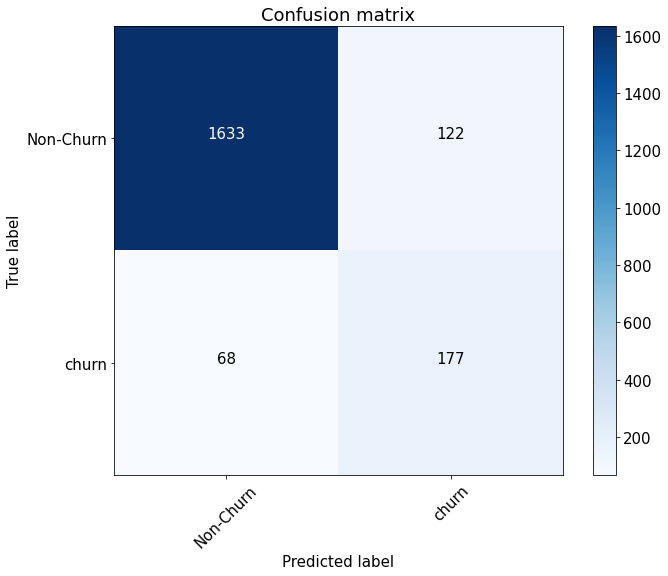

In [34]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("img/conf_matrix_2.png")
plt.show()

In [35]:
roc_auc_score(y_test, preds)

0.9354357811500669

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [36]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [37]:
get_user_embedding(user_articles_list)

array([0.        , 0.04274968, 0.0057535 , 0.        , 0.20006428,
       0.        , 0.09094648, 0.        , 0.        , 0.34668843,
       0.        , 0.        , 0.        , 0.        , 0.05950103,
       0.        , 0.        , 0.07947629, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [38]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.000000,0.0,0.452876,0.008336,0.000000,0.0,0.000000,...,0.000000,0.042796,0.000000,0.0,0.018240,0.000000,0.0,0.0,0.0,0.0
1,u108690,0.017502,0.000000,0.000000,0.0,0.203750,0.000000,0.103546,0.0,0.011528,...,0.007272,0.000000,0.008126,0.0,0.030325,0.000000,0.0,0.0,0.0,0.0
2,u108339,0.000000,0.040292,0.035964,0.0,0.352530,0.007059,0.085560,0.0,0.017887,...,0.052865,0.005322,0.000000,0.0,0.006696,0.011022,0.0,0.0,0.0,0.0


In [39]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.000000,0.0,0.452876,0.008336,0.000000,0.0,0.000000,...,0.042796,0.000000,0.0,0.018240,0.000000,0.0,0.0,0.0,0.0,0
1,u108690,0.017502,0.000000,0.000000,0.0,0.203750,0.000000,0.103546,0.0,0.011528,...,0.000000,0.008126,0.0,0.030325,0.000000,0.0,0.0,0.0,0.0,1
2,u108339,0.000000,0.040292,0.035964,0.0,0.352530,0.007059,0.085560,0.0,0.017887,...,0.005322,0.000000,0.0,0.006696,0.011022,0.0,0.0,0.0,0.0,1


In [40]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [41]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [42]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.39436308, 0.0125623 , 0.31182512, 0.14553319, 0.10780498,
       0.03258425, 0.19794737, 0.02777803, 0.10882103, 0.07139375])

Рассчитаем Precision, Recall, F_score

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.264276, F-Score=0.648, Precision=0.591, Recall=0.718


Confusion matrix, without normalization
[[1633  122]
 [  70  175]]


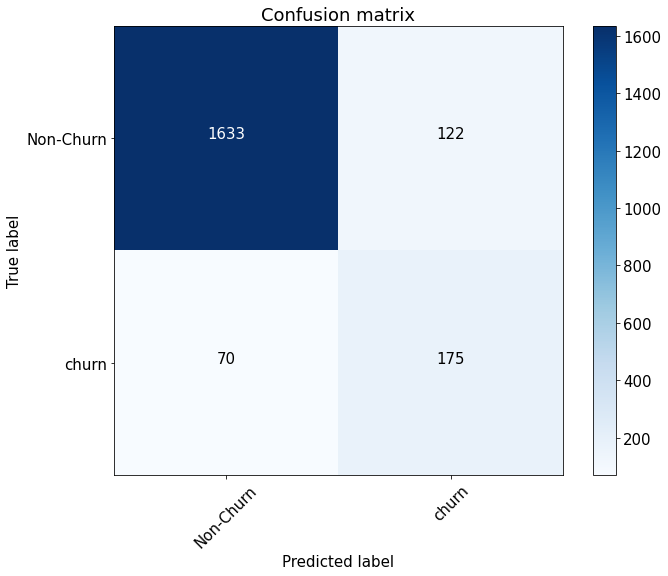

In [44]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("img/conf_matrix_2.png")
plt.show()

In [45]:
roc_auc_score(y_test, preds)

0.9370730856445142

3. Повторить п.2, но используя уже не медиану, а max

In [46]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [47]:
get_user_embedding(user_articles_list)

array([0.        , 0.23677291, 0.17285125, 0.        , 0.43545401,
       0.03527365, 0.37299111, 0.        , 0.02933247, 0.44819471,
       0.        , 0.054127  , 0.07729755, 0.01971493, 0.19113202,
       0.03854973, 0.05421214, 0.14738204, 0.01883251, 0.10242976,
       0.13511859, 0.        , 0.01718875, 0.        , 0.01189756])

In [48]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.060489,0.024425,0.122428,0.606282,0.159706,0.000000,0.0,0.000000,...,0.069323,0.223159,0.130201,0.0,0.173008,0.000000,0.032914,0.081171,0.000000,0.0
1,u108690,0.022627,0.018219,0.085599,0.014726,0.384614,0.107882,0.225109,0.0,0.090252,...,0.053800,0.000000,0.141840,0.0,0.161694,0.046298,0.011622,0.098703,0.026304,0.0
2,u108339,0.000000,0.079027,0.075884,0.000000,0.484069,0.053125,0.198649,0.0,0.025833,...,0.106227,0.139366,0.254974,0.0,0.121192,0.056166,0.000000,0.012229,0.000000,0.0


In [49]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.060489,0.024425,0.122428,0.606282,0.159706,0.000000,0.0,0.000000,...,0.223159,0.130201,0.0,0.173008,0.000000,0.032914,0.081171,0.000000,0.0,0
1,u108690,0.022627,0.018219,0.085599,0.014726,0.384614,0.107882,0.225109,0.0,0.090252,...,0.000000,0.141840,0.0,0.161694,0.046298,0.011622,0.098703,0.026304,0.0,1
2,u108339,0.000000,0.079027,0.075884,0.000000,0.484069,0.053125,0.198649,0.0,0.025833,...,0.139366,0.254974,0.0,0.121192,0.056166,0.000000,0.012229,0.000000,0.0,1


In [50]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [51]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [52]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12812827, 0.00341295, 0.8867094 , 0.50536859, 0.08010601,
       0.00111676, 0.07172394, 0.00184579, 0.1253101 , 0.13911211])

Рассчитаем Precision, Recall, F_score

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.350289, F-Score=0.775, Precision=0.770, Recall=0.780


Confusion matrix, without normalization
[[1698   57]
 [  55  190]]


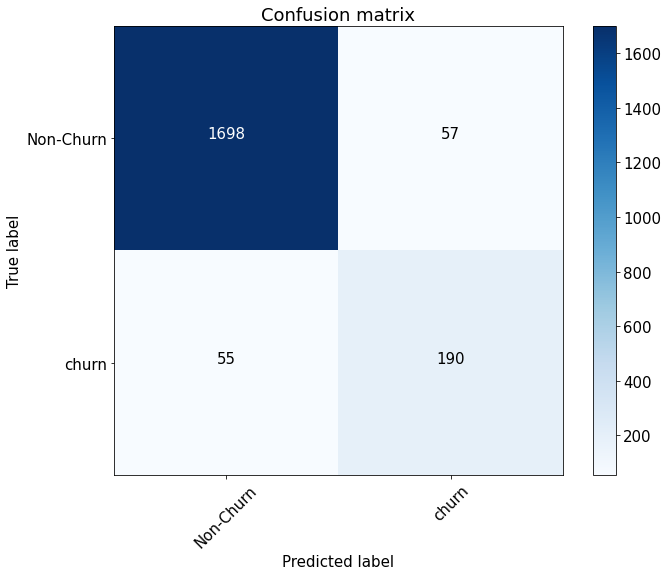

In [54]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("img/conf_matrix_2.png")
plt.show()

In [55]:
roc_auc_score(y_test, preds)

0.9712122797837084

4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [69]:
# создаём пустой ДатаФрейм
df = pd.DataFrame(columns=['model', 'roc_auc', 'precision', 'f_score'])
df

,model,roc_auc,precision,f_score


In [70]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, preds)

df = df.append({'model': 'mean', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)
df

Best Threshold=0.268784, F-Score=0.653, Precision=0.593, Recall=0.727


,model,roc_auc,precision,f_score
0,mean,0.935436,0.593333,0.653211


In [71]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, preds)

df = df.append({'model': 'median', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)
df

Best Threshold=0.264276, F-Score=0.648, Precision=0.591, Recall=0.718


,model,roc_auc,precision,f_score
0,mean,0.935436,0.593333,0.653211
1,median,0.937073,0.590604,0.648250


In [72]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, preds)

df = df.append({'model': 'max', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)
df

Best Threshold=0.350289, F-Score=0.775, Precision=0.770, Recall=0.780


,model,roc_auc,precision,f_score
0,mean,0.935436,0.593333,0.653211
1,median,0.937073,0.590604,0.648250
2,max,0.971212,0.770161,0.774848


In [73]:
df

,model,roc_auc,precision,f_score
0,mean,0.935436,0.593333,0.653211
1,median,0.937073,0.590604,0.648250
2,max,0.971212,0.770161,0.774848


6. Сделать самостоятельные выводы и предположения о том, почему тот или иной способ оказался эффективнее остальных